In [2]:
class Config:
    name = "CatBoost/Agg003"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None
    
    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [18]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')
import seaborn as sns
sns.set_palette("winter_r")

from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

## Environment Settings

In [4]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

In [5]:
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet'))
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv'))
train = train.merge(target, how='left', on='customer_ID')
test = pd.read_parquet(os.path.join(INPUT, 'test.parquet'))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(93), int16(9), int64(1), int8(86), object(2)
memory usage: 2.6+ GB


In [7]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,0,0,0.0,NaN,0,0.006527,0,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,0,0,0.0,NaN,0,0.008126,0,0


## Analyze Payment Columns

In [8]:
import re

p_columns = []
for col in train.columns:
    if re.match(r'P_\d', col):
        p_columns.append(col)
train = train[p_columns + ['customer_ID', Config.target]]
test = test[p_columns + ['customer_ID']]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   P_2          float32
 1   P_3          float32
 2   P_4          float32
 3   customer_ID  object 
 4   target       int64  
dtypes: float32(3), int64(1), object(1)
memory usage: 189.9+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   P_2          float32
 1   P_3          float32
 2   P_4          float32
 3   customer_ID  object 
dtypes: float32(3), object(1)
memory usage: 216.7+ MB


In [11]:
train.head()

,P_2,P_3,P_4,customer_ID,target
0,0.938469,0.736463,0.0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,0.936665,0.720886,0.0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
2,0.954180,0.738044,0.0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
3,0.960384,0.741813,0.0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
4,0.947248,0.691986,0.0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0


In [12]:
train.describe()

,P_2,P_3,P_4,target
count,5.485466e+06,5.229959e+06,5.531451e+06,5.531451e+06
mean,6.581885e-01,6.012673e-01,1.392159e-01,2.490972e-01
std,2.441398e-01,1.700240e-01,3.395976e-01,4.324903e-01
min,-4.589548e-01,-1.519690e+00,0.000000e+00,0.000000e+00
25%,4.803307e-01,5.408657e-01,0.000000e+00,0.000000e+00
50%,6.942950e-01,6.183025e-01,0.000000e+00,0.000000e+00
75%,8.648159e-01,6.838264e-01,0.000000e+00,0.000000e+00
max,1.010000e+00,2.428051e+00,1.269390e+00,1.000000e+00


In [13]:
test.describe()

,P_2,P_3,P_4
count,1.130388e+07,1.091518e+07,1.136376e+07
mean,6.703143e-01,5.774883e-01,1.155313e-01
std,2.455860e-01,1.708790e-01,2.977352e-01
min,-4.658552e-01,-1.504840e+00,0.000000e+00
25%,4.863303e-01,5.377246e-01,0.000000e+00
50%,6.987661e-01,6.163250e-01,0.000000e+00
75%,8.649260e-01,6.820500e-01,0.000000e+00
max,1.010000e+00,2.632375e+00,1.236488e+00


## Histograms

<AxesSubplot:xlabel='P_2', ylabel='Density'>

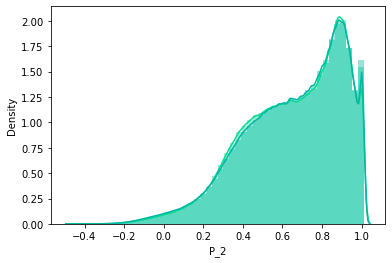

In [14]:
sns.distplot(train['P_2'])
sns.distplot(test['P_2'])

<AxesSubplot:xlabel='P_3', ylabel='Density'>

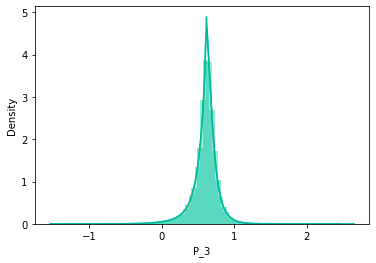

In [15]:
sns.distplot(train['P_3'])
sns.distplot(test['P_3'])

<AxesSubplot:xlabel='P_4', ylabel='Density'>

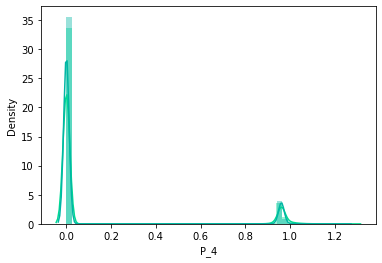

In [16]:
sns.distplot(train['P_4'])
sns.distplot(test['P_4'])

## Let's see corelation between target and P columns

In [34]:
def add_agg_features(df : pd.DataFrame):
    p_cols = ['P_2', 'P_3', 'P_4']
    df = df.groupby("customer_ID")[p_cols].agg(['mean', 'std', 'min', 'max', 'last'])
    df.columns = ['_'.join(x) for x in df.columns]
    df = df.reset_index(drop=False)
    return df
train_agg = add_agg_features(train)
train_agg = train_agg.merge(target, on='customer_ID', how='left')
test_agg = add_agg_features(test)

In [35]:
train_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_ID  458913 non-null  object 
 1   P_2_mean     456479 non-null  float32
 2   P_2_std      451084 non-null  float64
 3   P_2_min      456479 non-null  float32
 4   P_2_max      456479 non-null  float32
 5   P_2_last     456479 non-null  float32
 6   P_3_mean     437387 non-null  float32
 7   P_3_std      432255 non-null  float64
 8   P_3_min      437387 non-null  float32
 9   P_3_max      437387 non-null  float32
 10  P_3_last     437387 non-null  float32
 11  P_4_mean     458913 non-null  float32
 12  P_4_std      453793 non-null  float64
 13  P_4_min      458913 non-null  float32
 14  P_4_max      458913 non-null  float32
 15  P_4_last     458913 non-null  float32
 16  target       458913 non-null  int64  
dtypes: float32(12), float64(3), int64(1), object(1)
memory usage: 42.0+

<AxesSubplot:>

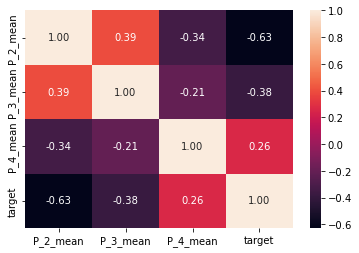

In [36]:
mean_cols = [col + '_mean' for col in p_columns]
sns.heatmap(train_agg[mean_cols + [Config.target]].corr(), annot=True, fmt='.2f')

<AxesSubplot:>

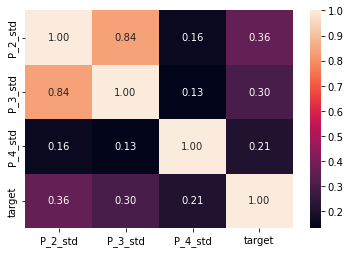

In [39]:
std_cols = [col + '_std' for col in p_columns]
sns.heatmap(train_agg[std_cols + [Config.target]].corr(), annot=True, fmt='.2f')

<AxesSubplot:>

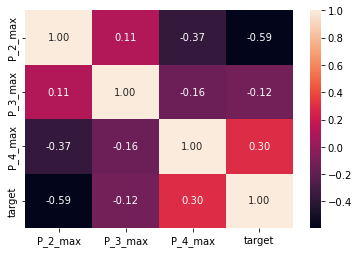

In [40]:
max_cols = [col + '_max' for col in p_columns]
sns.heatmap(train_agg[max_cols + [Config.target]].corr(), annot=True, fmt='.2f')

<AxesSubplot:>

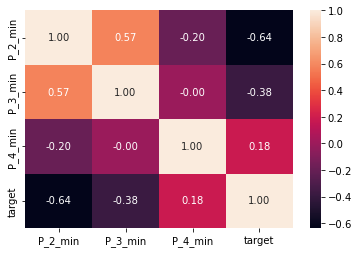

In [41]:
min_cols = [col + '_min' for col in p_columns]
sns.heatmap(train_agg[min_cols + [Config.target]].corr(), annot=True, fmt='.2f')

<AxesSubplot:>

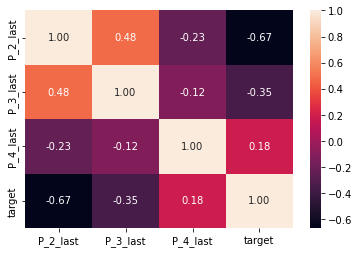

In [42]:
last_cols = [col + '_last' for col in p_columns]
sns.heatmap(train_agg[last_cols + [Config.target]].corr(), annot=True, fmt='.2f')

<AxesSubplot:>

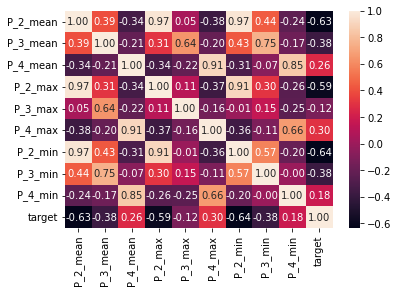

In [43]:
sns.heatmap(train_agg[mean_cols + max_cols + min_cols + [Config.target]].corr(), annot=True, fmt='.2f')

### Insight

1. P_2 has strong inverse corelation with target.
2. P_2 and P_3 may have corelation.

<AxesSubplot:xlabel='P_2_last', ylabel='Density'>

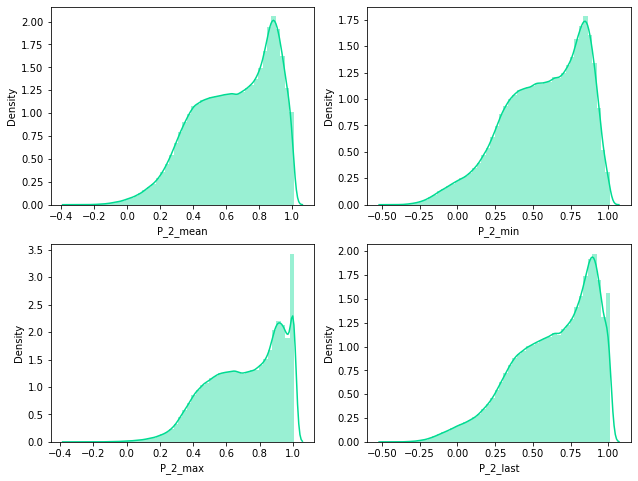

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(10.4, 8.0))
sns.distplot(train_agg['P_2_mean'], ax=ax1[0])
sns.distplot(train_agg['P_2_max'], ax=ax2[0])
sns.distplot(train_agg['P_2_min'], ax=ax1[1])
sns.distplot(train_agg['P_2_last'], ax=ax2[1])

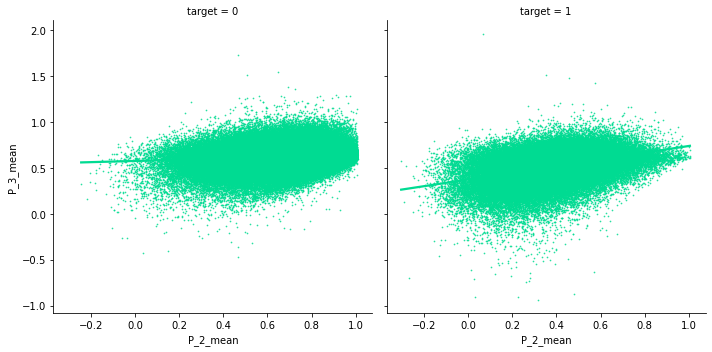

In [58]:
sns.lmplot(x='P_2_mean', y='P_3_mean', col=Config.target, data=train_agg, scatter_kws={'s': 0.5})

<AxesSubplot:xlabel='P_3_last', ylabel='Density'>

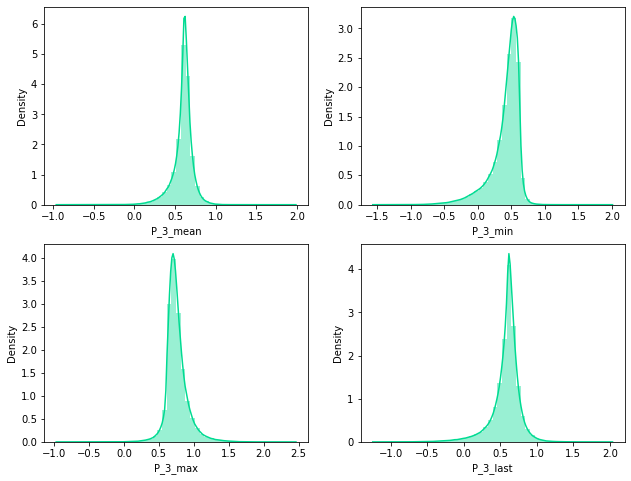

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(10.4, 8.0))
sns.distplot(train_agg['P_3_mean'], ax=ax1[0])
sns.distplot(train_agg['P_3_max'], ax=ax2[0])
sns.distplot(train_agg['P_3_min'], ax=ax1[1])
sns.distplot(train_agg['P_3_last'], ax=ax2[1])

<AxesSubplot:xlabel='P_4_last', ylabel='Density'>

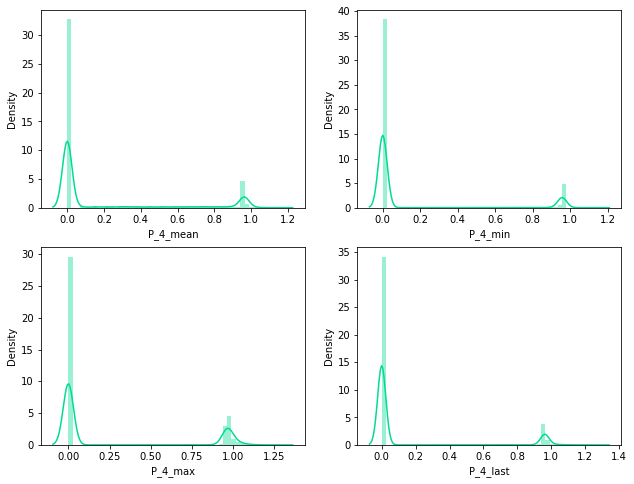

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(10.4, 8.0))
sns.distplot(train_agg['P_4_mean'], ax=ax1[0])
sns.distplot(train_agg['P_4_max'], ax=ax2[0])
sns.distplot(train_agg['P_4_min'], ax=ax1[1])
sns.distplot(train_agg['P_4_last'], ax=ax2[1])

## Behaviors depending on target

In [68]:
pos_samples = train_agg[train_agg[Config.target] == 1].sample(100)
neg_samples = train_agg[train_agg[Config.target] == 0].sample(100)

In [69]:
pos_samples.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,P_4_mean,P_4_std,P_4_min,P_4_max,P_4_last,target
173657,60bfbb9c7ff9066ae923473cd75653a06803142cfa9fcd...,0.380059,0.092212,0.223656,0.506525,0.443332,0.644626,0.200340,0.309148,1.027164,0.819498,0.000000,0.000000,0.000000,0.000000,0.00000,1
299411,a6b5c0a398f414701b1c9e9b16d40a328663baf5b5341e...,0.392654,0.146983,0.115285,0.505697,0.115285,0.606509,0.262247,-0.174403,0.826148,-0.174403,0.000000,0.000000,0.000000,0.000000,0.00000,1
372693,cfb460225ebc86961931063907230b57c59c8a981dcb0f...,0.780060,0.038753,0.705260,0.862747,0.705260,0.539239,0.104036,0.382932,0.725206,0.452091,0.000000,0.000000,0.000000,0.000000,0.00000,1
17407,09ccfe0fca48445d8d6735e3dd53e540d51ae62432a1b4...,0.349424,0.083953,0.275331,0.450574,0.279186,0.325326,0.000933,0.324666,0.325985,0.325985,0.960644,0.003431,0.956705,0.964920,0.95928,1
253812,8d44285cb73dec81778ba0dce985133849061604ac8e8a...,0.353649,0.022401,0.313938,0.378093,0.372254,0.577354,0.069240,0.488296,0.634820,0.489260,0.814454,0.361479,0.000000,0.965879,0.00000,1


In [70]:
neg_samples.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,P_4_mean,P_4_std,P_4_min,P_4_max,P_4_last,target
418161,e92539e310bc9fcd5aa31422d72bdae4bcd773e80ec265...,0.482360,0.024244,0.437639,0.514865,0.494261,0.620801,0.058920,0.516170,0.682052,0.642971,0.000000,0.000000,0.0,0.0000,0.0,0
134470,4ab87ddccfa822c9c21df2c3e55ad79b461fe12d630e5a...,0.698812,0.036088,0.646573,0.742066,0.742066,0.682552,0.104964,0.548053,0.842714,0.720627,0.000000,0.000000,0.0,0.0000,0.0,0
50142,1c1c39379a9dc0d09454e691ffbaf7531993706dd28b46...,0.647075,0.076700,0.520561,0.780225,0.574266,0.534262,0.142066,0.232630,0.789301,0.521879,0.000000,0.000000,0.0,0.0000,0.0,0
337943,bc4ba3c9cced3e37fbb267a04d08d6dae046441d1c64f6...,0.868332,0.070430,0.706378,0.952010,0.848364,0.603412,0.069269,0.486899,0.740431,0.602404,0.000000,0.000000,0.0,0.0000,0.0,0
178919,63b29ea3d7d03697767322c657bcf570e57620645cf30c...,0.501237,0.047176,0.432297,0.605619,0.524832,0.551061,0.114812,0.382352,0.685704,0.685704,0.739648,0.421669,0.0,0.9653,0.0,0


<AxesSubplot:xlabel='P_2_mean', ylabel='Density'>

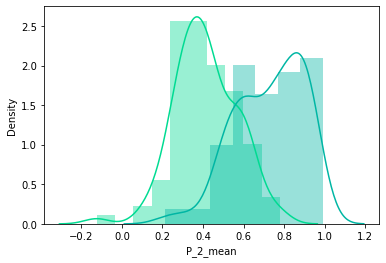

In [71]:
sns.distplot(pos_samples['P_2_mean'])
sns.distplot(neg_samples['P_2_mean'])

<AxesSubplot:xlabel='P_3_mean', ylabel='Density'>

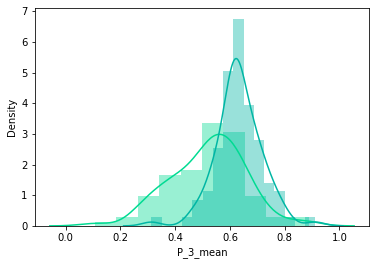

In [72]:
sns.distplot(pos_samples['P_3_mean'])
sns.distplot(neg_samples['P_3_mean'])

<AxesSubplot:xlabel='P_4_max', ylabel='Density'>

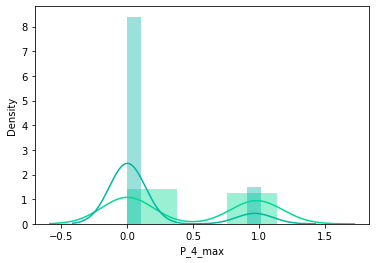

In [74]:
sns.distplot(pos_samples['P_4_mean'])
sns.distplot(neg_samples['P_4_mean'])

## Time series analysys depending on target

In [119]:
pos_samples = train_agg[train_agg[Config.target] == 1].sample(100)
neg_samples = train_agg[train_agg[Config.target] == 0].sample(100)

In [120]:
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet'))
pos_series = train.set_index('customer_ID').loc[pos_samples['customer_ID'], ['S_2', 'P_2', 'P_3', 'P_4']].reset_index(drop=False)
neg_series = train.set_index('customer_ID').loc[neg_samples['customer_ID'], ['S_2', 'P_2', 'P_3', 'P_4']].reset_index(drop=False)

In [121]:
pos_series['S_2_rank'] = pos_series.groupby('customer_ID')['S_2'].rank()
neg_series['S_2_rank'] = neg_series.groupby('customer_ID')['S_2'].rank()

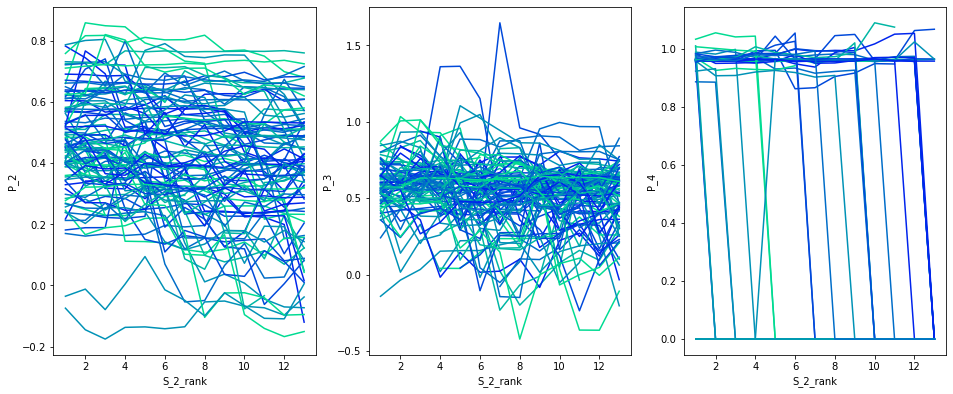

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(16.0, 6.4))
for customer_ID in pos_series['customer_ID'].unique():
    for i, col in enumerate(p_columns):
        sns.lineplot(x='S_2_rank', y=col, data=pos_series[pos_series['customer_ID'] == customer_ID], ax=ax[i])

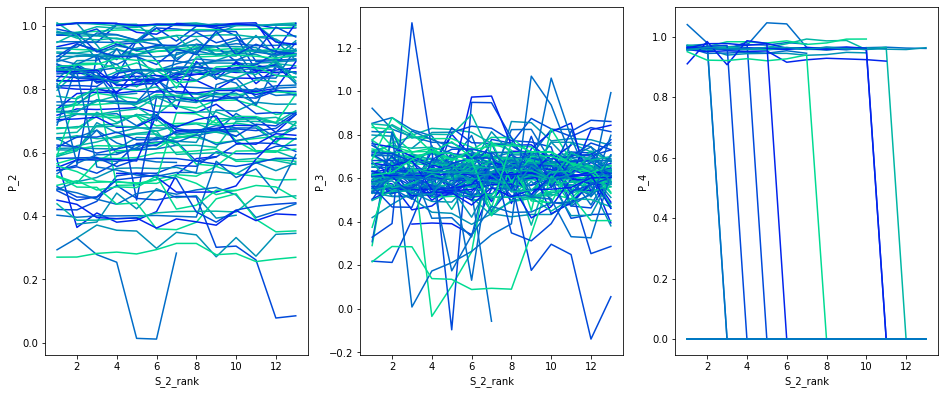

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(16.0, 6.4))
for customer_ID in neg_series['customer_ID'].unique():
    for i, col in enumerate(p_columns):
        sns.lineplot(x='S_2_rank', y=col, data=neg_series[neg_series['customer_ID'] == customer_ID], ax=ax[i])